# PyTorch: Autoencoder convolucional Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
#import multiprocessing
#multiprocessing.set_start_method("spawn", force=True)


In [2]:
# 1.0)
#!pip3 install torch torchvision torchaudio torchviz
# ¡Instalación con Pip apuntando directamente a la versión 11.8!
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu118


In [3]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [4]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
#import sklearn as skl
import pandas as pd
#import dill
import json

In [5]:
# 1.3
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [6]:
# 1.4)
#import google.colab
#from google.colab import files

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.version.cuda)

cuda
11.8


## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [8]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])#,transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)


print(len(train_set_orig))  # 60000
print(len(valid_set_orig))        # 10000''''''

60000
10000


In [9]:
'''from torch.utils.data import random_split, ConcatDataset

# Cargar ambos conjuntos completos (70.000)
train_full = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)
test_full  = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)

# Unimos todo en un único dataset
full_dataset = ConcatDataset([train_full, test_full])
total = len(full_dataset)  # 70000

# Definir proporciones (por ej: 85% train, 15% valid)
#train_size = int(0.85 * total)  # 59500 aprox
#valid_size = total - train_size # 10500 aprox

train_size = 40000 # 59500 aprox
valid_size = total - train_size # 10500 aprox

train_set, valid_set = random_split(full_dataset, [train_size, valid_size])

print(len(train_set))   # ~59500
print(len(valid_set))   # ~10500'''


"from torch.utils.data import random_split, ConcatDataset\n\n# Cargar ambos conjuntos completos (70.000)\ntrain_full = datasets.FashionMNIST('MNIST_data/', download=True, train=True, transform=transform)\ntest_full  = datasets.FashionMNIST('MNIST_data/', download=True, train=False, transform=transform)\n\n# Unimos todo en un único dataset\nfull_dataset = ConcatDataset([train_full, test_full])\ntotal = len(full_dataset)  # 70000\n\n# Definir proporciones (por ej: 85% train, 15% valid)\n#train_size = int(0.85 * total)  # 59500 aprox\n#valid_size = total - train_size # 10500 aprox\n\ntrain_size = 40000 # 59500 aprox\nvalid_size = total - train_size # 10500 aprox\n\ntrain_set, valid_set = random_split(full_dataset, [train_size, valid_size])\n\nprint(len(train_set))   # ~59500\nprint(len(valid_set))   # ~10500"

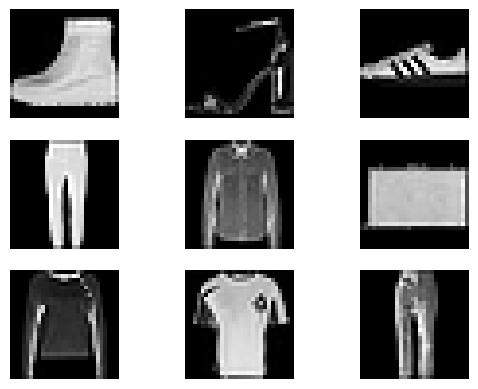

In [10]:
# 2.2)
figure = plt.figure()
cols,rows = 3,3
for i in range(1,cols*rows+1):
    j = torch.randint(len(train_set_orig),size=(1,)).item() # Los números aleatorios tambien se pueden generar desde pytorch. Util para trabajar en la GPU.
    image,label = train_set_orig[j]
    figure.add_subplot(rows,cols,i)
    plt.imshow(image.squeeze(), cmap="gray")  
    #plt.title(labels_names[label])
    plt.axis("off")

## Ejercicio 3) Creando un `DataSet` personalizado.

**1)** Con el fin de implementar un autoencoder, cree una clase derivada de la clase `DataSet` (llámela, por ejemplo `CustomDataset`) que, en vez de retornal el label asociado a cada imagen de `FashionMNIST`, retorne la imagen misma.

**2)** Utilice dicha clase para transformar los conjuntos de entrenamiento y testeo de `FashionMNIST` pensados para clasificación, a correspondientes conjuntos pensados para entrenar un autoencoder.
Para ello, defina una clase `CustomDataset` que deriva de la clase `Dataset`, cuyo método `__getitem__(self,i)` retorne el pair `input,output` donde tanto `input` cómo `output` son iguales a la $i$-ésima imagen del dataset.

In [11]:
# 3.1)
# Creamos una subclase de la clase Dataset que nos sirva para generar lotes de ejemplos que puedan usarse para entrenar un autoencoder
class CustomDataset(Dataset):
    def __init__(self,dataset):
        self.dataset=dataset
    # Redefinimos el método .__len__()
    def __len__(self):
        return len(self.dataset)
    # Redefinimos el método .__getitem__()
    def __getitem__(self,i):
        image,label=self.dataset[i]
        input  = image
        output = image #torch.flatten(image) # retornamos la imagen como salida
        return input,output

In [12]:
# 3.2)
# Convertimos FashionMNIST Dataset a CustomDataset
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

## Ejercicio 4) Red Neuronal Autoencoder Convolucional

**1)** Defina y cree una red neuronal *autoencoder convolucional* constituida por las siguientes capas:


1. Capa convolucional 2D (encoder) compuesta por:

  * Una capa `Conv2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) que mapea una entrada con $1$ canal y dimensiones $(28,28)$ a una salida con $16$ canales y dimensiones $(26,26)$.
    Utilice un kernel de dimensiones $(3,3)$ y el resto de los parámetros en sus valores por defecto.
  * Una capa `ReLU`.
  * Una capa `MaxPool2d` con un kernel de dimensiones $(2,2)$, de modo que la salida resultante tenga dimensiones $(16,13,13)$.
  * Una capa `Dropout` con probabilidad $p$.

2. Capa lineal (cuello de botella o “bottleneck”) compuesta por:

  * Una capa `Flatten` que transforma una entrada de dimensiones $(16,13,13)$ en un vector de dimensión $16\times 13\times 13 = 2704$.
  * Una capa `Linear` que mapea el vector de dimensión $2704$ a un vector de dimensión $n$ (donde $n$ es un número mucho menor, por ejemplo $n=128$, representando la *codificación comprimida* o *latente*).
  * Una capa `ReLU`.
  * Una capa `Linear` que mapea de nuevo el vector de dimensión $n$ al espacio original de dimensión $2704$.
  * Una capa `ReLU`.

3. Capa convolucional 2D transpuesta (decoder) compuesta por:

  * Una capa `Unflatten` que mapea el vector de dimensión $2704$ a una representación de $16$ canales con dimensiones $(13,13)$.
  * Una capa `ConvTranspose2d` (ver [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html)) que mapea $16$ canales de dimensiones $(13,13)$ a $1$ canal de dimensiones $(28,28)$. Utilice un kernel de dimensiones $(6,6)$, un stride de $(2,2)$, y un padding de $(1,1)$.
  * Una capa `Sigmoid`, para asegurar que las salidas se encuentren en el rango $[0,1]$ (asumiendo que las imágenes originales también fueron normalizadas en dicho rango).

**2)** Grafique, a modo de comparación, algunas imágenes de entrada y sus correspondientes reconstrucciones obtenidas con el modelo **sin entrenar** y con una probabilidad de *dropout* $p=0.2$.

In [13]:
# CASO0
'''
class NeuralNetwork(nn.Module):
    def __init__(self,n,p=0.2):
        super(NeuralNetwork,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3), #De 28x28x1 a 26x26x16. Son 16 filtros convolucionales. Cada filtro extrae una característica diferente. 
        #Si aca usamos padding=1, la salida sería 28x28x16 pues mantenemos las dimensiones espaciales debido a que el padding lo que hace es agregar una capa de ceros alrededor de la imagen.
        # Y si aca usamos stride=2, la salida sería 13x13x16, pues reducimos las dimensiones espaciales a la mitad. Ya que stride=2 significa que el filtro se mueve de a 2 pixeles en cada paso con lo cual se reduce la resolución espacial.
        # Si el tamaño del kernel aumentara a 5, la salida sería 24x24x16, pues el tamaño del kernel afecta las dimensiones espaciales de la salida.
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #Reducción de dimensionalidad: de 26x26 a 13x13, canales siguen siendo 16. 
            nn.Dropout(p),
            nn.Flatten(),#start_dim=(16,13,13)) #De 16x13x13 a 2704
            nn.Linear(16*13*13,n),#de 2704 a n, codificación 
            nn.ReLU(),
        )

        self.decoder =nn.Sequential(
            nn.Linear(n,16*13*13),  #de n a 2704, decodificación
            nn.ReLU(),
            nn.Unflatten(dim=1, unflattened_size=(16,13,13)), #de 2704 a 16x13x13
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=6,stride= 2, padding=1),  #de 16x13x13 a 28x28x1, son 28 porque usamos stride=2, que duplica las dimensiones espaciales.
            nn.Sigmoid() 
        )
    
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
                    
        return x

mi_red = NeuralNetwork(128,p=0.2)
'''

'\nclass NeuralNetwork(nn.Module):\n    def __init__(self,n,p=0.2):\n        super(NeuralNetwork,self).__init__()\n        self.encoder = nn.Sequential(\n            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3), #De 28x28x1 a 26x26x16. Son 16 filtros convolucionales. Cada filtro extrae una característica diferente. \n        #Si aca usamos padding=1, la salida sería 28x28x16 pues mantenemos las dimensiones espaciales debido a que el padding lo que hace es agregar una capa de ceros alrededor de la imagen.\n        # Y si aca usamos stride=2, la salida sería 13x13x16, pues reducimos las dimensiones espaciales a la mitad. Ya que stride=2 significa que el filtro se mueve de a 2 pixeles en cada paso con lo cual se reduce la resolución espacial.\n        # Si el tamaño del kernel aumentara a 5, la salida sería 24x24x16, pues el tamaño del kernel afecta las dimensiones espaciales de la salida.\n            nn.ReLU(),\n            nn.MaxPool2d(kernel_size=2, stride=2), #Reducción d

In [14]:
# CASO1
'''
class NeuralNetwork(nn.Module):
    def __init__(self, n, p=0.2):
        super(NeuralNetwork, self).__init__()

         # Encoder convolucional
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # -> 14x14
            nn.Dropout(p),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  # -> 7x7
            nn.Dropout(p),
            nn.Flatten(), # ->32*7*7 = 1568 
            nn.Linear(32*7*7, n), #-> n
        )

        # Decoder convolucional
        self.decoder = nn.Sequential(
            nn.Linear(n, 32*7*7),
            nn.Unflatten(dim=1, unflattened_size=(32,7,7)),
            nn.ConvTranspose2d(32, 16, 2, stride=2),  # -> 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 2, stride=2),   # -> 1x28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        return x


mi_red = NeuralNetwork(128,p=0.2)
'''

'\nclass NeuralNetwork(nn.Module):\n    def __init__(self, n, p=0.2):\n        super(NeuralNetwork, self).__init__()\n\n         # Encoder convolucional\n        self.encoder = nn.Sequential(\n            nn.Conv2d(1, 16, 3, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(2,2),  # -> 14x14\n            nn.Dropout(p),\n\n            nn.Conv2d(16, 32, 3, padding=1),\n            nn.ReLU(),\n            nn.MaxPool2d(2,2),  # -> 7x7\n            nn.Dropout(p),\n            nn.Flatten(), # ->32*7*7 = 1568 \n            nn.Linear(32*7*7, n), #-> n\n        )\n\n        # Decoder convolucional\n        self.decoder = nn.Sequential(\n            nn.Linear(n, 32*7*7),\n            nn.Unflatten(dim=1, unflattened_size=(32,7,7)),\n            nn.ConvTranspose2d(32, 16, 2, stride=2),  # -> 16x14x14\n            nn.ReLU(),\n            nn.ConvTranspose2d(16, 1, 2, stride=2),   # -> 1x28x28\n            nn.Sigmoid()\n        )\n\n    def forward(self, x):\n        x = self.encoder(x)\n

In [15]:
#CASO2
''''''
class NeuralNetwork(nn.Module):
    def __init__(self,n, p=0.2):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),  # 28x28 -> 28x28x32
            nn.ReLU(),
            nn.MaxPool2d(2,2),               # 28x28 -> 14x14
            nn.Dropout(p),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),               # 14x14 -> 7x7
            #nn.Dropout(p)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),                    # -> 14x14x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2),                     # -> 28x28x1
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
mi_red = NeuralNetwork(128,p=0.2)

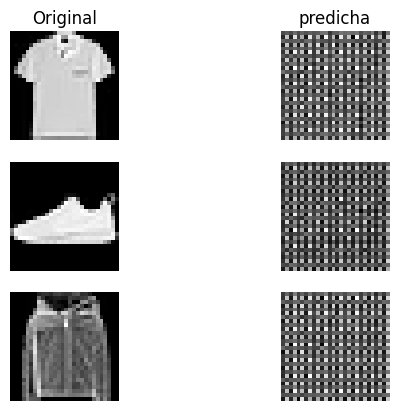

In [16]:
n = 128
p = 0.2
model = NeuralNetwork(n, p = p)
model.to(device)



def unbatch(x):
  return x.squeeze().detach().cpu().numpy() # (1,28,28) -> (28,28)

def batch(x):
  return x.unsqueeze(0)   # (28,28) -> (1,28,28)

# Miramos que imagenes predice el modelo sin entrenar
figure = plt.figure()
rows,cols = 3,2
i = 0   #subplot index
for row in range(1, rows+1):
  j = torch.randint(len(train_set),size=(1,)).item()
  # Ploteamos la imagen original
  i = i + 1
  image,_ = train_set[j]
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('Original')
  plt.axis("off")
  plt.imshow(unbatch(image),cmap="Greys_r")
  # Ploteamos la imagen predicha
  i = i + 1
  figure.add_subplot(rows,cols,i)
  if row==1:
    plt.title('predicha')
  plt.axis("off")
  image_pred = unbatch(model(batch(image).to(device)).cpu())
  plt.imshow(image_pred,cmap="Greys_r")
plt.show()


## Ejercicio 5) Entrenando el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de prueba o validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` que estén definidos sobre  el `train_set` (conjunto de entranmiento) y el `valid_set` (conjunto de prueba) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando el **Error Cuadrático Medio**.

**5)** Cree un optimizador con un learning rate igual a $10^{-3}$.
Pruebe con **ADAM**.

**6)** Cree una instancia del modelo con dropout $p=0.2$.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop que itere sobre épocas de entrenamiento y validación, y que guarde en listas correspondientes los siguientes valores del **ECM**:
*  promedios (incorrectos) sobre el conjunto de entrenamiento, calculado **durante** el proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de entrenamiento, calculados **posteriormente** al proceso de entrenamiento sobre la época.
*  promedios (correctos) sobre el conjunto de validación, calculados **posteriormente** al proceso de entrenamiento sobre la época.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso **8)** para graficar en función de las **épocas de entrenamiento** el **ECM** de **entrenamiento** y **validación**, respectivamente.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Grafique, comparativamente, algunas de las imagenes a predecir vs las imagenes predichas por el modelo entrenado.

**12)** Repita para otras elecciones de los hiperparámetros tales como, el optimizador (podría ser el **SGD**), el **learning-rate**, el tamaño de los **batchs**, el **dropout**, **capas convolucionales** y **convolucionales traspuestas** de otros tamaños.
En particular, pruebe eliminando, adecuadamente, la **capa lineal**.
Que valores de estos hiperparámetros considera los más convenientes? Porqué?

In [17]:
# 5.1)
def train_loop(dataloader,model,loss_fn,optimizer):
    model.train()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for batch, (X,y) in enumerate(dataloader): 
        #enumerate devuelve una lista de tuplas (indice, valor), entonces al hacer
        # for batch, (X,y) desestructura la tupla en indice(batch) y valor(X(imagenes), y(etiquetas))

        # Copiamos las salidas y entradas al dispositivo de trabajo
        X, y = X.to(device,non_blocking=True), y.to(device,non_blocking=True)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        batch_size = len(X)
        # calculamos la perdida promedio del batch y lo agregamos a una suma correspondiente
        sum_loss += loss.item() * batch_size # loss = suma de perdidas en el batch / batch_size => loss.item() * batch_size = suma de perdidas en el batch

        # En este caso no tiene sentido calcular la cantidad de predicciones correctas porque es un autoencoder y no una tarea de clasificación
        #sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # actualizamos la cantidad de muestras procesadas
        sum_samples += batch_size

       
        avrg_loss = sum_loss / sum_samples
        # precision = sum_correct / sum_samples 
        if batch % (num_batches / 100) == 0: 
            print(f"  Batch {batch:>5d}/{num_batches:>5d} - avrg_Loss: {avrg_loss:>7f}  processed_samples: {100*sum_samples/num_samples:>5f}%") #5d ?
        
    assert num_samples == sum_samples, "Error en el conteo de muestras procesadas"
    avrg_loss = sum_loss / sum_samples
    #precision = sum_correct / sum_samples

    return avrg_loss #, precision

In [18]:
#5.2)
def valid_loop(dataloader,model,loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    with torch.no_grad(): # es un context manager que desactiva el cálculo del gradiente momentáneamente, 
        #para ahorrar memoria y mejorar el rendimiento durante la evaluación del modelo.

        for X,y in dataloader: #iteramos sobre los batches del dataloader, esto es posible ya que si bien dataloader no es una lista,
            # implementa el protocolo iterable de python, por lo que se puede usar en un for, y en cada iteracion genera un batch nuevo

            # Copiamos las salidas y entradas al dispositivo de trabajo
            X, y = X.to(device,non_blocking=True), y.to(device,non_blocking=True)
            batch_size = len(X)
            sum_samples += batch_size

            pred = model(X)
            loss = loss_fn(pred, y)

            sum_loss += loss.item() * batch_size
            #sum_correct += (pred.argmax(1) == y).type(tor ch.float).sum().item()
    
    assert num_samples == sum_samples, "Error en el conteo de muestras procesadas"
    avrg_loss = sum_loss / sum_samples
    #precision = sum_correct / sum_samples
    #print(f"@eval_loop_avg_loss={avrg_loss:>8f}") #, precision={100*precision:0.1f}%")

    return avrg_loss #, precision

In [19]:
# 5.3)
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True,num_workers=8, pin_memory=True,persistent_workers=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True,num_workers=8, pin_memory=True,persistent_workers=True)

In [20]:
#5.4)
#Creamos una instancia de una funcion de perdida, en este caso error cuadratico medio
loss_fn = nn.MSELoss()

In [21]:
#5.6)
#valores segun ej4
n = 128
p = 0.2
model = NeuralNetwork(n, p = p)

#5.5)
#definimos el optimizador, en este caso SGD
learning_rate = 1e-3
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [22]:
#5.7)
#definimos el dispositivo de trabajo, una cpu o una gpu si esta disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pasamos el modelo al dispositivo
model = model.to(device)
print(device)

cuda


In [23]:
#5.8) y 5.9)
import time
from torch.utils.data import Subset


# Variables para la detección de Overfitting (Early Stopping)
best_valid_loss = float('inf') # La mejor (mínima) pérdida de validación observada hasta ahora
epochs_no_improve = 0            # Contador de épocas sin mejora en la pérdida de validación
patience = 5                     # Número de épocas a esperar después de la última mejora
overfitting_detected = False     # Flag para indicar si se detectó overfitting
overfitting_epoch = -1           # Época en la que se detectó el overfitting
overfitting_train_loss = -1.0
overfitting_valid_loss = -1.0


t_i = time.time()
num_epochs = 50
list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precisiom_incorrecta = []
list_train_precision = []
list_valid_precision = []

num_train_eval = 10000
num_total_train = len(train_set)
indices = torch.randperm(num_total_train)[:num_train_eval]
valid_train_set = Subset(train_set, indices)
valid_train_loader = torch.utils.data.DataLoader(valid_train_set, batch_size = batch_size, shuffle = True)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:\n-------------------------------")
    train_avg_loss_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
    train_avg_loss = valid_loop(valid_train_loader, model, loss_fn)
    valid_avg_loss = valid_loop(valid_loader, model, loss_fn)

    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)

    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)


    # --- Lógica de Detección de Overfitting ---
    if not overfitting_detected:
        if valid_avg_loss < best_valid_loss:
            best_valid_loss = valid_avg_loss
        elif patience<0 and not overfitting_detected:
            overfitting_detected = True
            overfitting_epoch = epoch + 1 # +1 porque epoch es base 0
            overfitting_train_loss = train_avg_loss
            overfitting_valid_loss = valid_avg_loss
            print(f"\n***POSIBLE OVERFITTING DETECTADO***")
            print(f"La pérdida de validación no mejoró o aumentó en la **Época {overfitting_epoch}**.")
            print(f"Loss de Entrenamiento (Evaluación 10k): {overfitting_train_loss:.4f}")
            print(f"Loss de Validación (Mejor anterior): {best_valid_loss:.4f}")
            print(f"Loss de Validación (Actual): {overfitting_valid_loss:.4f}\n")
        else:
            patience=patience-1
    # --------------------------------------------


    if (epoch + 1) % 10 == 0:
        print(f"\n---------------------------------------------")
        print(f"Epoch {epoch+1}/{num_epochs}: train(eval 10k)={train_avg_loss:.4f}, valid(10k)={valid_avg_loss:.4f}")
        print("\n")


print(f"Tiempo de ejecución: {(time.time()-t_i)/60:.2f} minutos")
print("Training complete.")

# Reporte final si se detectó overfitting
if overfitting_detected:
    print("\n--- Resumen de Overfitting ---")
    print(f"Posible Overfitting detectado en la Época: **{overfitting_epoch}**")
    print(f"Loss de Entrenamiento (Evaluación 10k) en ese momento: {overfitting_train_loss:.4f}")
    print(f"Loss de Validación en ese momento: {overfitting_valid_loss:.4f}")
    print(f"La mejor Loss de Validación fue: {best_valid_loss:.4f} (en la época anterior).")
else:
    print("\n--- Resumen ---")
    print("No se detectó un aumento de la Loss de Validación durante el entrenamiento.")

Epoch 1/50:
-------------------------------
  Batch     0/  235 - avrg_Loss: 0.153692  processed_samples: 0.426667%
Epoch 2/50:
-------------------------------
  Batch     0/  235 - avrg_Loss: 0.011613  processed_samples: 0.426667%
Epoch 3/50:
-------------------------------
  Batch     0/  235 - avrg_Loss: 0.008541  processed_samples: 0.426667%
Epoch 4/50:
-------------------------------
  Batch     0/  235 - avrg_Loss: 0.007244  processed_samples: 0.426667%
Epoch 5/50:
-------------------------------
  Batch     0/  235 - avrg_Loss: 0.006447  processed_samples: 0.426667%
Epoch 6/50:
-------------------------------
  Batch     0/  235 - avrg_Loss: 0.006292  processed_samples: 0.426667%
Epoch 7/50:
-------------------------------
  Batch     0/  235 - avrg_Loss: 0.005620  processed_samples: 0.426667%
Epoch 8/50:
-------------------------------
  Batch     0/  235 - avrg_Loss: 0.005765  processed_samples: 0.426667%
Epoch 9/50:
-------------------------------
  Batch     0/  235 - avrg_L

In [24]:

from datetime import datetime
timestamp = datetime.now().strftime("%m%d_%H%M")

# Guardar el encoder por separado
torch.save({
    'encoder_state_dict': model.encoder.state_dict(),
}, f"encoder_{timestamp}.pth")

# Guardar el modelo completo
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, f"autoencoder_{timestamp}.pth")

'''
#cargamos el modelo guardado
model = NeuralNetwork(128, 0.2)
nombre = "./TP_FINAL/CASO0/caso0.pth"
model.load_state_dict(torch.load(nombre))
model = model.to(device)
model.eval()
'''

'\n#cargamos el modelo guardado\nmodel = NeuralNetwork(128, 0.2)\nnombre = "./TP_FINAL/CASO0/caso0.pth"\nmodel.load_state_dict(torch.load(nombre))\nmodel = model.to(device)\nmodel.eval()\n'

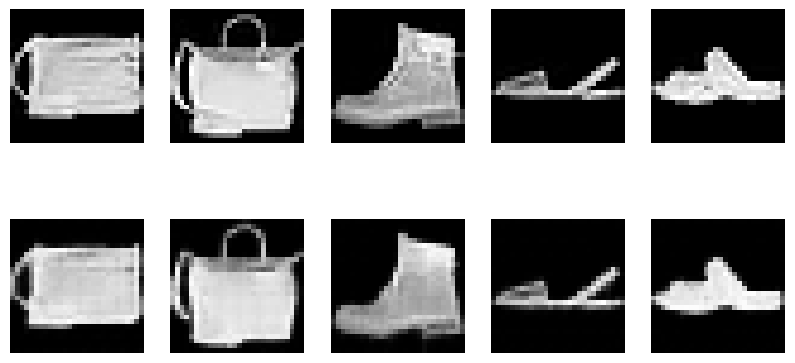

In [25]:
# probando la red entrenada con un ejemplito
numero_img = 0
imgs_before = []
imgs_after = []
for i in range(5):  # Cambiamos el rango para probar varias imágenes
    dataiter = iter(valid_loader)
    images, labels = next(dataiter)

    img = images[numero_img]  # Agregar dimensión de batch
    imgs_before.append(img.cpu().squeeze())
    # Pasar la imagen por el modelo
    with torch.no_grad():
        img = img.to(device)
        output = model(img.unsqueeze(0))  # Agregar dimensión de batch
        imgs_after.append(output.cpu().squeeze())

#comparacion imagen original vs reconstruida
#imagen:
figure = plt.figure()
#ajustamos el tamaño de la figura
figure.set_size_inches(10, 5)  # Ajusta el tamaño de la figura
cols,rows = 5,2
#graficamos arriba las 5 figuras originales y abajo las 5 reconstruidas
for i in range(len(imgs_before)):
    figure.add_subplot(rows,cols,i+1)
    plt.imshow(imgs_before[i], cmap='gray')
    plt.axis("off")
for i in range(len(imgs_after)):
    figure.add_subplot(rows,cols,i+1+5)  # Agregamos las imágenes reconstruidas en la segunda fila
    plt.imshow(imgs_after[i], cmap='gray')
    plt.axis("off")
plt.show()

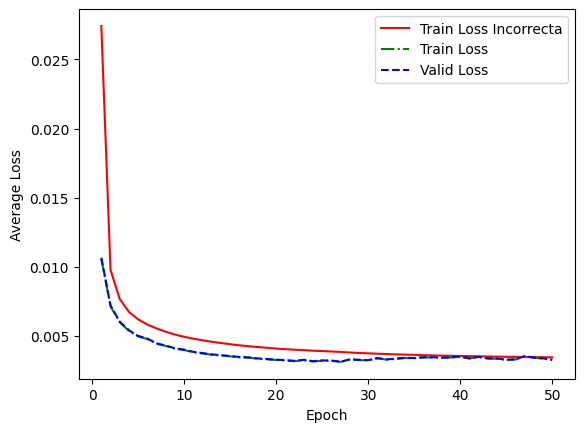

'\nplt.xlabel("Epoch")\nplt.ylabel("Precision")\nplt.plot(range(1,len(list_train_precisiom_incorrecta)+1),  list_train_precisiom_incorrecta, label="Train Precision Incorrecta",linestyle=\'-\', c=\'red\')\nplt.plot(range(1,len(list_train_precision)+1),  list_train_precision, label="Train Precision",linestyle=\'-\', c=\'green\')\nplt.plot(range(1,len(list_valid_precision)+1), list_valid_precision, label="Valid Precision",linestyle=\'--\', c=\'blue\')\nplt.legend()\n#plt.title("")\nplt.show() '

In [26]:
#5.10)
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.plot(range(1,len(list_train_avg_loss_incorrecta)+1), list_train_avg_loss_incorrecta, label="Train Loss Incorrecta",linestyle='-', c='red')
plt.plot(range(1,len(list_train_avg_loss)+1), list_train_avg_loss, label="Train Loss",linestyle='-.', c='green')
plt.plot(range(1,len(list_valid_avg_loss)+1), list_valid_avg_loss, label="Valid Loss",linestyle='--', c='blue')
plt.legend()
#plt.title("")
plt.show()
'''
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.plot(range(1,len(list_train_precisiom_incorrecta)+1),  list_train_precisiom_incorrecta, label="Train Precision Incorrecta",linestyle='-', c='red')
plt.plot(range(1,len(list_train_precision)+1),  list_train_precision, label="Train Precision",linestyle='-', c='green')
plt.plot(range(1,len(list_valid_precision)+1), list_valid_precision, label="Valid Precision",linestyle='--', c='blue')
plt.legend()
#plt.title("")
plt.show() '''

